# install contextily can use:
    
`conda install contextily --channel conda-forge`    

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import re
from collections import Counter
from nltk.corpus import stopwords

%matplotlib inline


## Adding a background map to plots
This example shows how you can add a background basemap to plots created with the geopandas .plot() method. This makes use of the contextily package to retrieve web map tiles from several sources (OpenStreetMap, Stamen).

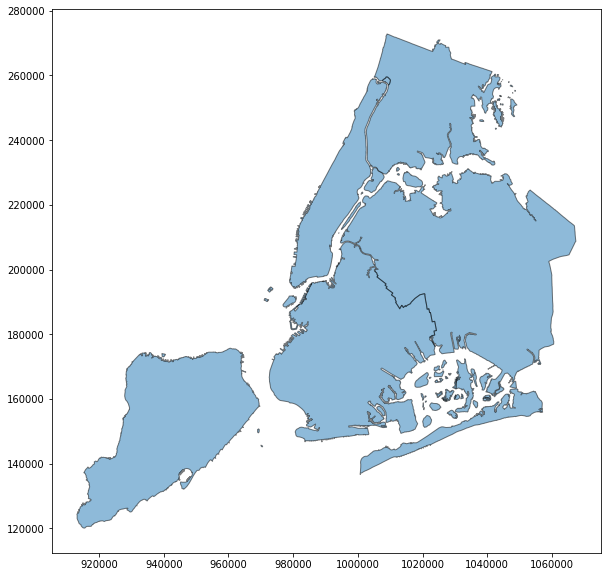

In [4]:
df = gpd.read_file(gpd.datasets.get_path('nybb'))
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

## Convert the data to Web Mercator
Web map tiles are typically provided in Web Mercator (EPSG 3857), so we need to make sure to convert our data first to the same CRS to combine our polygons and background tiles in the same map:

In [6]:
df = df.to_crs(epsg=3857)

## Add background tiles to plot
We can use add_basemap function of contextily to easily add a background map to our plot. :

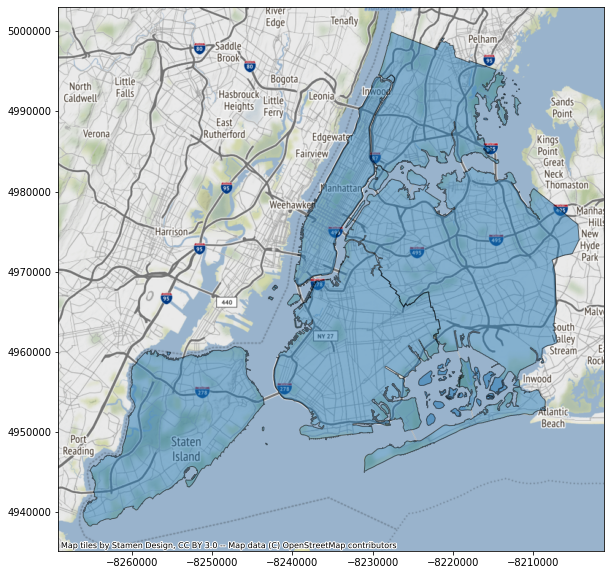

In [7]:
import contextily as ctx
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

We can control the detail of the map tiles using the optional zoom keyword (be careful to not specify a too high zoom level, as this can result in a large download).:

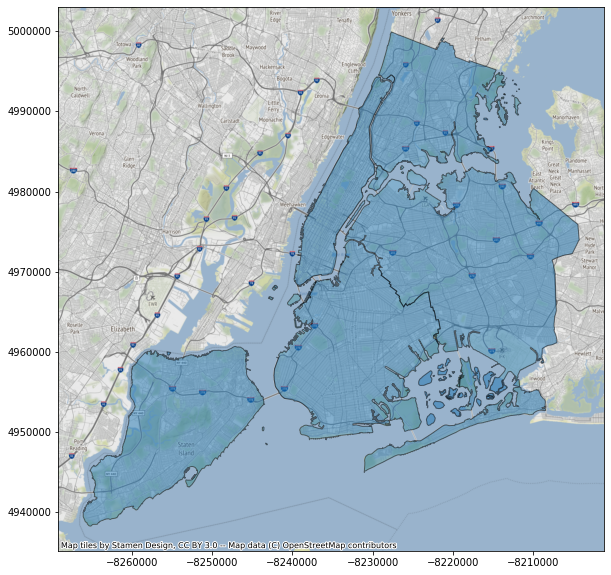

In [8]:
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=12)

By default, contextily uses the Stamen Terrain style. We can specify a different style using `ctx.providers`:

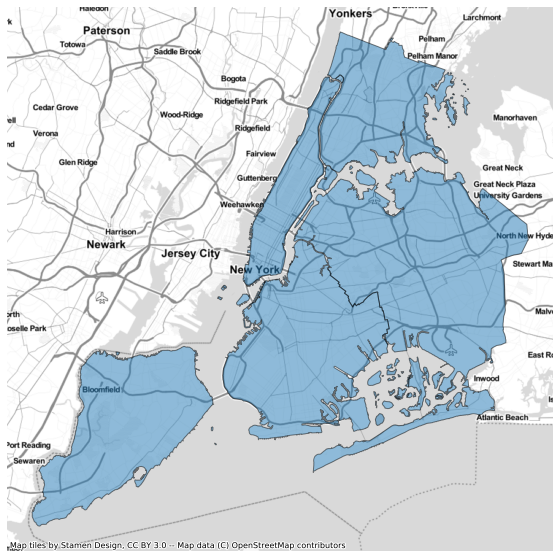

In [11]:
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

# Install Geoplot:
`conda install geoplot -c conda-forge`

## Plotting with Geoplot and GeoPandas
Geoplot is a Python library providing a selection of easy-to-use geospatial visualizations. It is built on top of the lower-level CartoPy, covered in a separate section of this tutorial, and is designed to work with GeoPandas input.

This example is a brief tour of the geoplot API. For more details on the library refer to its [documentation](https://residentmario.github.io/geoplot/index.html).

First we’ll load in the data using GeoPandas.

In [13]:
import geoplot

world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
boroughs = gpd.read_file(
    geoplot.datasets.get_path('nyc_boroughs')
)
collisions = gpd.read_file(
    geoplot.datasets.get_path('nyc_injurious_collisions')
)

## Plotting with Geoplot
We start out by replicating the basic GeoPandas world plot using Geoplot.

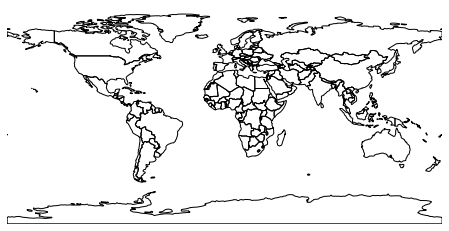

In [14]:
geoplot.polyplot(world, figsize=(8, 4))

Geoplot can re-project data into any of the map projections provided by CartoPy (see the list [here](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)).

/Users/xuhao3/opt/anaconda3/lib/python3.7/site-packages/geoplot/geoplot.py:680: UserWarning: Plot extent lies outside of the Orthographic projection's viewport. Defaulting to global extent.
  'Plot extent lies outside of the Orthographic projection\'s '


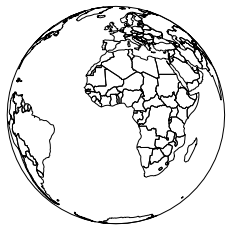

In [15]:
# use the Orthographic map projection (e.g. a world globe)
ax = geoplot.polyplot(
    world, projection=geoplot.crs.Orthographic(), figsize=(8, 4)
)
ax.outline_patch.set_visible(True)

`polyplot` is trivial and can only plot the geometries you pass to it. If you want to use color as a visual variable, specify a `choropleth`. Here we sort GDP per person by country into five buckets by color.

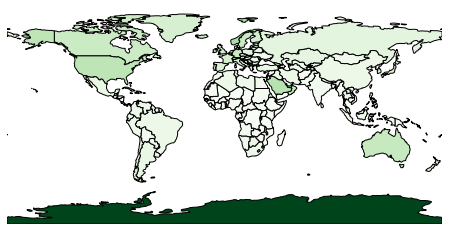

In [16]:
geoplot.choropleth(
    world, hue=world['gdp_md_est'] / world['pop_est'],
    cmap='Greens', figsize=(8, 4)
)

If you want to use size as a visual variable, use a `cartogram`. Here are population estimates for countries in Africa.

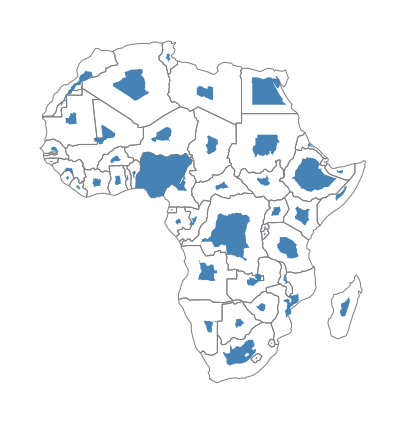

In [17]:
africa = world.query('continent == "Africa"')
ax = geoplot.cartogram(
    africa, scale='pop_est', limits=(0.2, 1),
    edgecolor='None', figsize=(7, 8)
)
geoplot.polyplot(africa, edgecolor='gray', ax=ax)

If we have data in the shape of points in space, we may generate a three-dimensional heatmap on it using `kdeplot`.

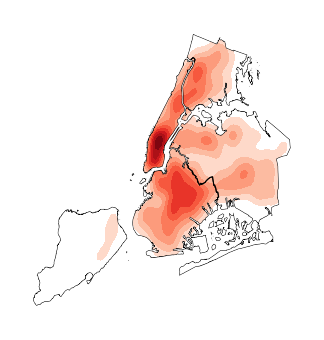

In [18]:
ax = geoplot.kdeplot(
    collisions, clip=boroughs.geometry,
    shade=True, cmap='Reds',
    projection=geoplot.crs.AlbersEqualArea())
geoplot.polyplot(boroughs, ax=ax, zorder=1)

Alternatively, we may partition the space into neighborhoods automatically, using Voronoi tessellation. This is a good way of visually verifying whether or not a certain data column is spatially correlated.

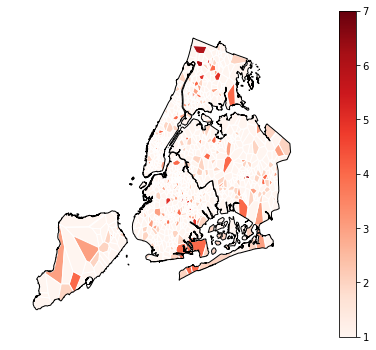

In [20]:
ax = geoplot.voronoi(
    collisions.head(1000), projection=geoplot.crs.AlbersEqualArea(),
    clip=boroughs.simplify(0.001),
    hue='NUMBER OF PERSONS INJURED', cmap='Reds', scheme=None,
    legend=True,
    edgecolor='white'
)
geoplot.polyplot(boroughs, edgecolor='black', zorder=1, ax=ax)

## Creating a GeoDataFrame from a DataFrame with coordinates
This example shows how to create a `GeoDataFrame` when starting from a regular `DataFrame` that has coordinates either WKT (well-known text) format, or in two columns.



### From longitudes and latitudes
First, let’s consider a DataFrame containing cities and their respective longitudes and latitudes.

In [21]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

A `GeoDataFrame` needs a `shapely` object. We use geopandas `points_from_xy()` to transform **Longitude** and **Latitude** into a list of `shapely.Point` objects and set it as a `geometry` while creating the `GeoDataFrame`. (note that `points_from_xy()` is an enhanced wrapper for `[Point(x, y) for x, y in zip(df.Longitude, df.Latitude)])`

In [26]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [27]:
print(gdf.head())

           City    Country  Latitude  Longitude                     geometry
0  Buenos Aires  Argentina    -34.58     -58.66  POINT (-58.66000 -34.58000)
1      Brasilia     Brazil    -15.78     -47.91  POINT (-47.91000 -15.78000)
2      Santiago      Chile    -33.45     -70.66  POINT (-70.66000 -33.45000)
3        Bogota   Colombia      4.60     -74.08    POINT (-74.08000 4.60000)
4       Caracas  Venezuela     10.48     -66.86   POINT (-66.86000 10.48000)


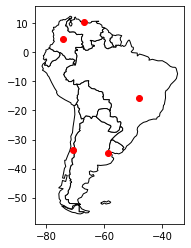

In [29]:
# Finally, we plot the coordinates over a country-level map.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

## From WKT format
Here, we consider a DataFrame having coordinates in WKT format.

In [30]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Coordinates': ['POINT(-58.66 -34.58)', 'POINT(-47.91 -15.78)',
                     'POINT(-70.66 -33.45)', 'POINT(-74.08 4.60)',
                     'POINT(-66.86 10.48)']})

We use `shapely.wkt` sub-module to parse wkt format:

In [31]:
from shapely import wkt

df['Coordinates'] = df['Coordinates'].apply(wkt.loads)

The GeoDataFrame is constructed as follows :

In [33]:
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')

print(gdf.head())

           City    Country                  Coordinates
0  Buenos Aires  Argentina  POINT (-58.66000 -34.58000)
1      Brasilia     Brazil  POINT (-47.91000 -15.78000)
2      Santiago      Chile  POINT (-70.66000 -33.45000)
3        Bogota   Colombia    POINT (-74.08000 4.60000)
4       Caracas  Venezuela   POINT (-66.86000 10.48000)


Again, we can plot our GeoDataFrame

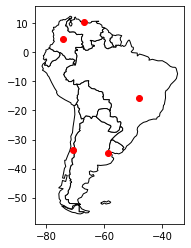

In [34]:
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')

plt.show()

## Plotting with CartoPy and GeoPandas
Converting between GeoPandas and CartoPy for visualizing data.

[CartoPy](https://scitools.org.uk/cartopy/docs/latest/) is a Python library that specializes in creating geospatial visualizations. It has a slightly different way of representing Coordinate Reference Systems (CRS) as well as constructing plots. This example steps through a round-trip transfer of data between GeoPandas and CartoPy.

First we’ll load in the data using GeoPandas.

In [35]:
# sphinx_gallery_thumbnail_number = 7
from cartopy import crs as ccrs

path = gpd.datasets.get_path('naturalearth_lowres')
df = gpd.read_file(path)
# Add a column we'll use later
df['gdp_pp'] = df['gdp_md_est'] / df['pop_est']

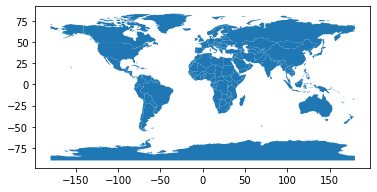

In [36]:
df.plot()

### Plotting with CartoPy
Cartopy also handles Shapely objects well, but it uses a different system for CRS. To plot this data with CartoPy, we’ll first need to project it into a new CRS. We’ll use a CRS defined within CartoPy and use the GeoPandas `to_crs` method to make the transformation.

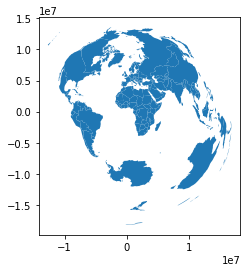

In [37]:
# Define the CartoPy CRS object.
crs = ccrs.AzimuthalEquidistant()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_ae = df.to_crs(crs_proj4)

# Here's what the plot looks like in GeoPandas
df_ae.plot()

Now that our data is in a CRS based off of CartoPy, we can easily plot it.

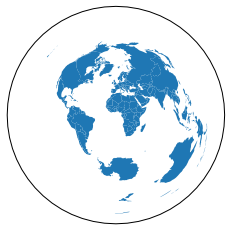

In [39]:
fig, ax = plt.subplots(subplot_kw={'projection': crs})
ax.add_geometries(df_ae['geometry'], crs=crs)

Note that we could have easily done this with an EPSG code like so:

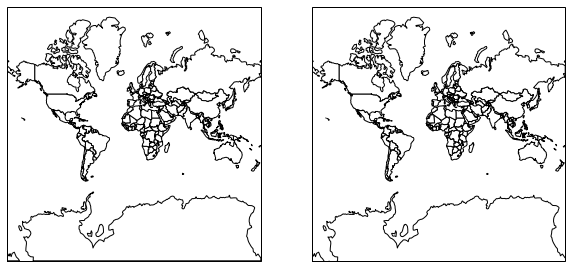

In [42]:
crs_epsg = ccrs.epsg('3857')
df_epsg = df.to_crs(epsg='3857')

# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 5))
# Make the CartoPy plot
axs[0].add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='white', edgecolor='black')
# Make the GeoPandas plot
df_epsg.plot(ax=axs[1], color='white', edgecolor='black')

## CartoPy to GeoPandas
Next we’ll perform a CRS projection in CartoPy, and then convert it back into a GeoPandas object.

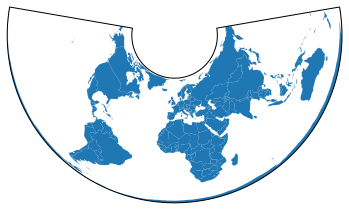

In [43]:
crs_new = ccrs.AlbersEqualArea()
new_geometries = [crs_new.project_geometry(ii, src_crs=crs)
                  for ii in df_ae['geometry'].values]

fig, ax = plt.subplots(subplot_kw={'projection': crs_new})
ax.add_geometries(new_geometries, crs=crs_new)

Now that we’ve created new Shapely objects with the CartoPy CRS, we can use this to create a GeoDataFrame.

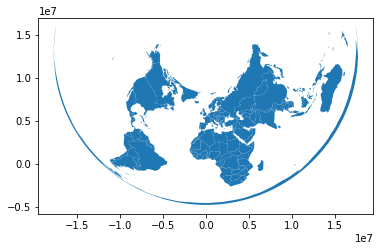

In [45]:
df_aea = gpd.GeoDataFrame(df['gdp_pp'], geometry=new_geometries,
                                crs=crs_new.proj4_init)
df_aea.plot()

We can even combine these into the same figure. Here we’ll plot the shapes of the countries with CartoPy. We’ll then calculate the centroid of each with GeoPandas and plot it on top.

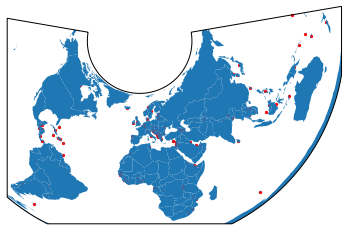

In [46]:
# Generate a CartoPy figure and add the countries to it
fig, ax = plt.subplots(subplot_kw={'projection': crs_new})
ax.add_geometries(new_geometries, crs=crs_new)

# Calculate centroids and plot
df_aea_centroids = df_aea.geometry.centroid
df_aea_centroids.plot(ax=ax, markersize=5, color='r')

plt.show()

## Data Structures
GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas Series and DataFrame, respectively.

### GeoSeries
A GeoSeries is essentially a vector where each entry in the vector is a set of shapes corresponding to one observation. An entry may consist of only one shape (like a single polygon) or multiple shapes that are meant to be thought of as one observation (like the many polygons that make up the State of Hawaii or a country like Indonesia).

geopandas has three basic classes of geometric objects (which are actually shapely objects):

- Points / Multi-Points

- Lines / Multi-Lines

- Polygons / Multi-Polygons

Note that all entries in a GeoSeries need not be of the same geometric type, although certain export operations will fail if this is not the case.

### Overview of Attributes and Methods
The GeoSeries class implements nearly all of the attributes and methods of Shapely objects. When applied to a GeoSeries, they will apply elementwise to all geometries in the series. Binary operations can be applied between two GeoSeries, in which case the operation is carried out elementwise. The two series will be aligned by matching indices. Binary operations can also be applied to a single geometry, in which case the operation is carried out for each element of the series with that geometry. In either case, a Series or a GeoSeries will be returned, as appropriate.

A short summary of a few attributes and methods for GeoSeries is presented here, and a full list can be found in the all attributes and methods page. There is also a family of methods for creating new shapes by expanding existing shapes or applying set-theoretic operations like “union” described in geometric manipulations.

### Attributes
- area: shape area (units of projection – see projections)

- bounds: tuple of max and min coordinates on each axis for each shape

- total_bounds: tuple of max and min coordinates on each axis for entire GeoSeries

- geom_type: type of geometry.

- is_valid: tests if coordinates make a shape that is reasonable geometric shape (according to this).

### Basic Methods
- distance(other): returns Series with minimum distance from each entry to other

- centroid: returns GeoSeries of centroids

- representative_point(): returns GeoSeries of points that are guaranteed to be within each geometry. It does NOT return centroids.

- to_crs(): change coordinate reference system. See projections

- plot(): plot GeoSeries. See mapping.

### Relationship Tests
- geom_almost_equals(other): is shape almost the same as other (good when floating point precision issues make shapes slightly different)

- contains(other): is shape contained within other

- intersects(other): does shape intersect other

### GeoDataFrame
A GeoDataFrame is a tabular data structure that contains a GeoSeries.

The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame’s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column.

The “geometry” column – no matter its name – can be accessed through the geometry attribute (gdf.geometry), and the name of the geometry column can be found by typing gdf.geometry.name.

A GeoDataFrame may also contain other columns with geometrical (shapely) objects, but only one column can be the active geometry at a time. To change which column is the active geometry column, use the set_geometry method.

An example using the worlds GeoDataFrame:

In [48]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [50]:
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

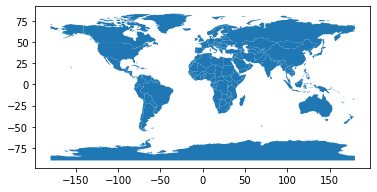

In [55]:
world.geometry.plot()

Currently, the column named “geometry” with country borders is the active geometry column:

In [57]:
world.geometry.name

'geometry'

We can also rename this column to “borders”:

In [59]:
world = world.rename(columns={'geometry': 'borders'}).set_geometry('borders')
world.geometry.name

'borders'

Now, we create centroids and make it the geometry:

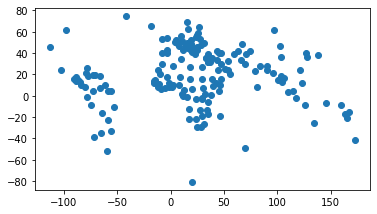

In [60]:
world['centroid_column'] = world.centroid
world = world.set_geometry('centroid_column')
world.plot();


Note: A GeoDataFrame keeps track of the active column by name, so if you rename the active geometry column, you must also reset the geometry:

`gdf = gdf.rename(columns={'old_name': 'new_name'}).set_geometry('new_name')`

Note 2: Somewhat confusingly, by default when you use the read_file command, the column containing spatial objects from the file is named “geometry” by default, and will be set as the active geometry column. However, despite using the same term for the name of the column and the name of the special attribute that keeps track of the active column, they are distinct. You can easily shift the active geometry column to a different GeoSeries with the set_geometry command. Further, gdf.geometry will always return the active geometry column, not the column named geometry. `If you wish to call a column named “geometry”, and a different column is the active geometry column, use gdf['geometry'], not gdf.geometry`.

## Attributes and Methods
Any of the attributes calls or methods described for a GeoSeries will work on a GeoDataFrame – effectively, they are just applied to the “geometry” GeoSeries.

However, GeoDataFrames also have a few extra methods for input and output which are described on the Input and Output page and for geocoding with are described in Geocoding.

## Display options
GeoPandas has an options attribute with currently a single configuration option to control:

In [61]:
gpd.options

Options(
  display_precision: None [default: None]
      The precision (maximum number of decimals) of the coordinates in the
      WKT representation in the Series/DataFrame display. By default (None),
      it tries to infer and use 3 decimals for projected coordinates and 5
      decimals for geographic coordinates.)

In [62]:
# they have 5 decimalsm
world['centroid_column'].head()

0    POINT (163.85316 -17.31631)
1      POINT (34.75299 -6.25773)
2     POINT (-12.13783 24.29117)
3     POINT (-98.14238 61.46908)
4    POINT (-112.59944 45.70563)
Name: centroid_column, dtype: geometry

In [63]:
# If you want to change this, for example to see more decimals, you can do:
gpd.options.display_precision = 9

In [64]:
world['centroid_column'].head()

0    POINT (163.853164645 -17.316309426)
1      POINT (34.752989855 -6.257732429)
2     POINT (-12.137831112 24.291172960)
3     POINT (-98.142381372 61.469076145)
4    POINT (-112.599435912 45.705628002)
Name: centroid_column, dtype: geometry

# Reading and Writing Files
## Reading Spatial Data
geopandas can read almost any vector-based spatial data format including ESRI shapefile, GeoJSON files and more using the command:

`geopandas.read_file()`

which returns a GeoDataFrame object. (This is possible because geopandas makes use of the great fiona library, which in turn makes use of a massive open-source program called GDAL/OGR designed to facilitate spatial data transformations).

Any arguments passed to read_file() after the file name will be passed directly to fiona.open, which does the actual data importation. In general, read_file is pretty smart and should do what you want without extra arguments, but for more help, type:

`import fiona; help(fiona.open)`

Among other things, one can explicitly set the driver (shapefile, GeoJSON) with the driver keyword, or pick a single layer from a multi-layered file with the layer keyword:

`countries_gdf = geopandas.read_file("package.gpkg", layer='countries')`

Where supported in fiona, geopandas can also load resources directly from a web URL, for example for GeoJSON files from geojson.xyz:

`url = "http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
df = geopandas.read_file(url)`

geopandas can also get data from a PostGIS database using the read_postgis() command.

## Writing Spatial Data
GeoDataFrames can be exported to many different standard formats using the GeoDataFrame.to_file() method. For a full list of supported formats, type import fiona; `fiona.supported_drivers`.

#### Writing to Shapefile:

`countries_gdf.to_file("countries.shp")`
#### Writing to GeoJSON:

`countries_gdf.to_file("countries.geojson", driver='GeoJSON')`
#### Writing to GeoPackage:

`countries_gdf.to_file("package.gpkg", layer='countries', driver="GPKG")
cities_gdf.to_file("package.gpkg", layer='cities', driver="GPKG")`

## Indexing and Selecting Data
GeoPandas inherits the standard pandas methods for indexing/selecting data. This includes label based indexing with .loc and integer position based indexing with .iloc, which apply to both GeoSeries and GeoDataFrame objects. For more information on indexing/selecting, see the pandas documentation.

In addition to the standard pandas methods, GeoPandas also provides coordinate based indexing with the cx indexer, which slices using a bounding box. Geometries in the GeoSeries or GeoDataFrame that intersect the bounding box will be returned.

Using the world dataset, we can use this functionality to quickly select all countries whose boundaries extend into the southern hemisphere.

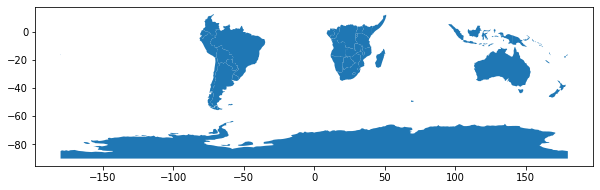

In [66]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
southern_world = world.cx[:, :0]
southern_world.plot(figsize=(10, 3));

## Mapping Tools
geopandas provides a high-level interface to the matplotlib library for making maps. Mapping shapes is as easy as using the plot() method on a GeoSeries or GeoDataFrame.

Loading some example data:

In [67]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [68]:
# We can now plot those GeoDataFrames:
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.000000000 -16.067132664, 1...  
1  POLYGON ((33.903711197 -0.950000000, 34.072620...  
2  POLYGON ((-8.665589565 27.656425890, -8.665124...  
3  MULTIPOLYGON (((-122.840000000 49.000000000, -...  
4  MULTIPOLYGON (((-122.840000000 49.000000000, -...

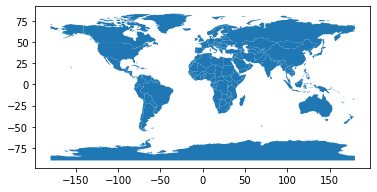

In [69]:
# Basic plot, random colors
world.plot();

Note that in general, any options one can pass to pyplot in matplotlib (or style options that work for lines) can be passed to the plot() method.

## Choropleth Maps
geopandas makes it easy to create Choropleth maps (maps where the color of each shape is based on the value of an associated variable). Simply use the plot command with the column argument set to the column whose values you want used to assign colors.

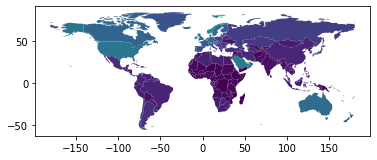

In [70]:
# Plot by GDP per capta
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

world.plot(column='gdp_per_cap');

## Creating a legend
When plotting a map, one can enable a legend using the legend argument:

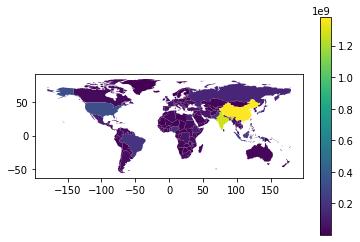

In [71]:
# Plot population estimates with an accurate legend

fig, ax = plt.subplots(1, 1)

world.plot(column='pop_est', ax=ax, legend=True)

However, the default appearance of the legend and plot axes may not be desirable. One can define the plot axes (with ax) and the legend axes (with cax) and then pass those in to the plot call. The following example uses mpl_toolkits to vertically align the plot axes and the legend axes:

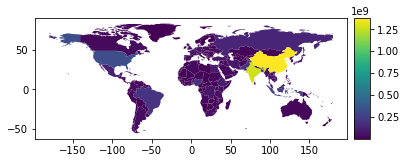

In [72]:
# Plot population estimates with an accurate legend
In [11]: from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]: fig, ax = plt.subplots(1, 1)

In [13]: divider = make_axes_locatable(ax)

In [14]: cax = divider.append_axes("right", size="5%", pad=0.1)

In [15]: world.plot(column='pop_est', ax=ax, legend=True, cax=cax)

And the following example plots the color bar below the map and adds its label using legend_kwds:

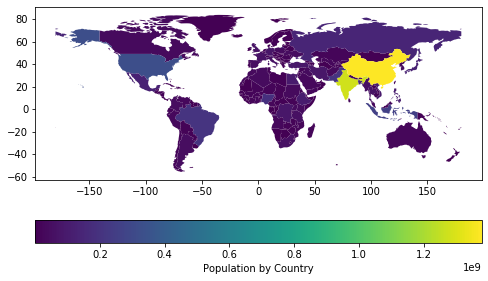

In [75]:
# Plot population estimates with an accurate legend
In [17]: fig, ax = plt.subplots(1, 1,figsize = (8,5))

In [18]: world.plot(column='pop_est',
   ....:            ax=ax,
   ....:            legend=True,
   ....:            legend_kwds={'label': "Population by Country",
   ....:                         'orientation': "horizontal"})


## Choosing colors
One can also modify the colors used by plot with the cmap option (for a full list of colormaps, see the matplotlib website):

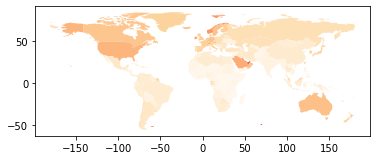

In [76]:
world.plot(column='gdp_per_cap', cmap='OrRd');

The way color maps are scaled can also be manipulated with the scheme option (if you have mapclassify installed, which can be accomplished via `conda install -c conda-forge mapclassify`). The scheme option can be set to any scheme provided by mapclassify (e.g. ‘box_plot’, ‘equal_interval’, ‘fisher_jenks’, ‘fisher_jenks_sampled’, ‘headtail_breaks’, ‘jenks_caspall’, ‘jenks_caspall_forced’, ‘jenks_caspall_sampled’, ‘max_p_classifier’, ‘maximum_breaks’, ‘natural_breaks’, ‘quantiles’, ‘percentiles’, ‘std_mean’ or ‘user_defined’). Arguments can be passed in classification_kwds dict. See the mapclassify documentation for further details about these map classification schemes.

### conda install -c conda-forge mapclassify

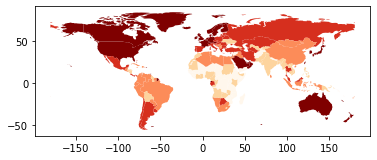

In [81]:
world.plot(column='gdp_per_cap', cmap='OrRd', scheme='quantiles')

## Maps with Layers
There are two strategies for making a map with multiple layers – one more succinct, and one that is a little more flexible.

Before combining maps, however, remember to always ensure they share a common CRS (so they will align).

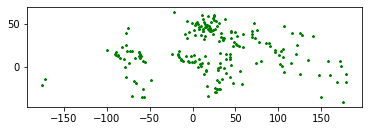

In [83]:
# Look at capitals
# Note use of standard `pyplot` line style options
In [21]: cities.plot(marker='*', color='green', markersize=5);

# Check crs
In [22]: cities = cities.to_crs(world.crs)
    
# Now we can overlay over country outlines
# And yes, there are lots of island capitals
# apparently in the middle of the ocean!

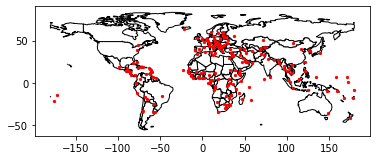

In [85]:
# Method 1

base = world.plot(color='white', edgecolor='black')

cities.plot(ax=base, marker='o', color='red', markersize=5);

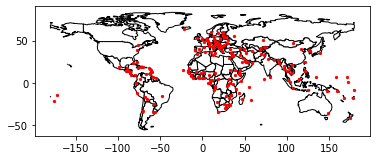

In [87]:
# Method 2: Using matplotlib objects

fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')
cities.plot(ax=ax, marker='o', color='red', markersize=5)
plt.show();

## Managing Projections
### Coordinate Reference Systems
CRS are important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates related to places on the Earth.

CRS are referred to using codes called proj4 strings. You can find the codes for most commonly used projections from www.spatialreference.org.

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection. One proj4 representation of this projection is:`"+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs".` 

But common projections can also be referred to by EPSG codes, so this same projection can also called using the proj4 string `"+init=epsg:4326"`.

geopandas can accept lots of representations of CRS, including the proj4 string itself (`"+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"`) or parameters broken out in a dictionary: `{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}`). In addition, some functions will take EPSG codes directly.

For reference, a few very common projections and their proj4 strings:

- WGS84 Latitude/Longitude: `"+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"` or `"+init=epsg:4326"`

- UTM Zones (North): `"+proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"`

- UTM Zones (South): `"+proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +south"`

### Setting a Projection
There are two relevant operations for projections: setting a projection and re-projecting.

Setting a projection may be necessary when for some reason geopandas has coordinate data (x-y values), but no information about how those coordinates refer to locations in the real world. Setting a projection is how one tells geopandas how to interpret coordinates. If no CRS is set, geopandas geometry operations will still work, but coordinate transformations will not be possible and exported files may not be interpreted correctly by other software.

Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the from_file() command) should always include projection information. You can see an objects current CRS through the crs attribute: my_geoseries.crs.

From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

For example, if you convert a spreadsheet of latitudes and longitudes into a GeoSeries by hand, you would set the projection by assigning the WGS84 latitude-longitude CRS to the crs attribute:

`my_geoseries.crs = {'init' :'epsg:4326'}`
### Re-Projecting
Re-projecting is the process of changing the representation of locations from one coordinate system to another. All projections of locations on the Earth into a two-dimensional plane are distortions, the projection that is best for your application may be different from the projection associated with the data you import. In these cases, data can be re-projected using the to_crs command:

In [89]:
# load example data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Check original projection
# (it's Platte Carre! x-y are long and lat)
world.crs


{'init': 'epsg:4326'}

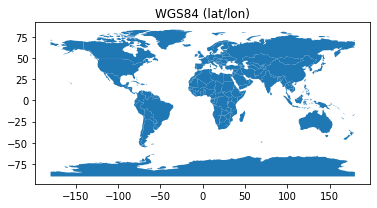

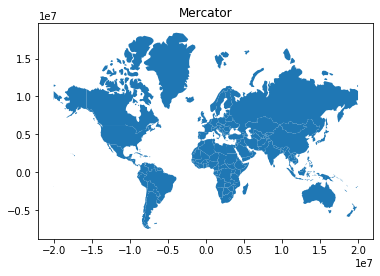

In [90]:
# Visualize
ax = world.plot()

ax.set_title("WGS84 (lat/lon)");

# Reproject to Mercator (after dropping Antartica)
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]

world = world.to_crs({'init': 'epsg:3395'}) # world.to_crs(epsg=3395) would also work

ax = world.plot()

ax.set_title("Mercator");

## Geometric Manipulations
geopandas makes available all the tools for geometric manipulations in the [*shapely* library](https://shapely.readthedocs.io/en/latest/manual.html).

Note that documentation for all set-theoretic tools for creating new shapes using the relationship between two different spatial datasets – like creating intersections, or differences – can be found on the [set operations page](https://geopandas.org/set_operations.html).

### Constructive Methods
`GeoSeries.buffer(distance, resolution=16)`
Returns a GeoSeries of geometries representing all points within a given distance of each geometric object.

`GeoSeries.boundary`
Returns a GeoSeries of lower dimensional objects representing each geometries’s set-theoretic boundary.

`GeoSeries.centroid`
Returns a GeoSeries of points for each geometric centroid.

`GeoSeries.convex_hull`
Returns a GeoSeries of geometries representing the smallest convex Polygon containing all the points in each object unless the number of points in the object is less than three. For two points, the convex hull collapses to a LineString; for 1, a Point.

`GeoSeries.envelope`
Returns a GeoSeries of geometries representing the point or smallest rectangular polygon (with sides parallel to the coordinate axes) that contains each object.

`GeoSeries.simplify(tolerance, preserve_topology=True)`
Returns a GeoSeries containing a simplified representation of each object.

`GeoSeries.unary_union`
Return a geometry containing the union of all geometries in the GeoSeries.

### Affine transformations
`GeoSeries.affine_transform(self, matrix)`
Transform the geometries of the GeoSeries using an affine transformation matrix

`GeoSeries.rotate(self, angle, origin='center', use_radians=False)`
Rotate the coordinates of the GeoSeries.

`GeoSeries.scale(self, xfact=1.0, yfact=1.0, zfact=1.0, origin='center')`
Scale the geometries of the GeoSeries along each (x, y, z) dimensio.

`GeoSeries.skew(self, angle, origin='center', use_radians=False)`
Shear/Skew the geometries of the GeoSeries by angles along x and y dimensions.

`GeoSeries.translate(self, xoff=0.0, yoff=0.0, zoff=0.0)`
Shift the coordinates of the GeoSeries.

### Examples of Geometric Manipulations

In [97]:
gpd.options.display_precision = 3

In [114]:
from geopandas import GeoSeries
from shapely.geometry import Polygon
p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = GeoSeries([p1, p2, p3])
g

0    POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00...
1    POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00...
2    POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00...
dtype: geometry

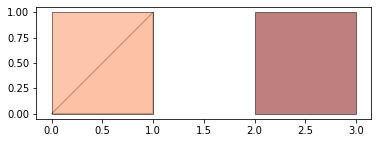

In [102]:
g.plot(cmap='OrRd', edgecolor = 'black',alpha = 0.5)

Some geographic operations return normal pandas object. The `area` property of a `GeoSeries` will return a `pandas.Series` containing the area of each item in the `GeoSeries`:

In [103]:
g.area

0    0.5
1    1.0
2    1.0
dtype: float64

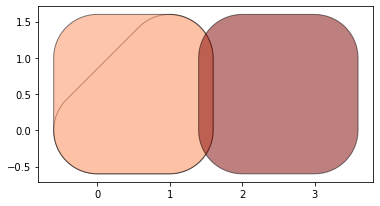

In [107]:
# Other operations return GeoPandas objects:
g.buffer(0.6).plot(cmap='OrRd', edgecolor = 'black',alpha = 0.5)

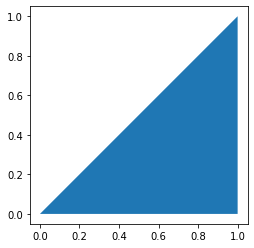

In [115]:
GeoSeries(g.iloc[0]).plot()

GeoPandas also implements alternate constructors that can read any data format recognized by [fiona](https://fiona.readthedocs.io/en/latest/). To read a zip file containing an ESRI shapefile with the borough boundaries of New York City (GeoPandas includes this as an example dataset):

In [116]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.read_file(nybb_path)
boros.set_index('BoroCode', inplace=True)
boros.sort_index(inplace=True)
boros

BoroName     Shape_Leng    Shape_Area  \
BoroCode                                               
1             Manhattan  359299.096471  6.364715e+08   
2                 Bronx  464392.991824  1.186925e+09   
3              Brooklyn  741080.523166  1.937479e+09   
4                Queens  896344.047763  3.045213e+09   
5         Staten Island  330470.010332  1.623820e+09   

                                                   geometry  
BoroCode                                                     
1         MULTIPOLYGON (((981219.056 188655.316, 980940....  
2         MULTIPOLYGON (((1012821.806 229228.265, 101278...  
3         MULTIPOLYGON (((1021176.479 151374.797, 102100...  
4         MULTIPOLYGON (((1029606.077 156073.814, 102957...  
5         MULTIPOLYGON (((970217.022 145643.332, 970227....

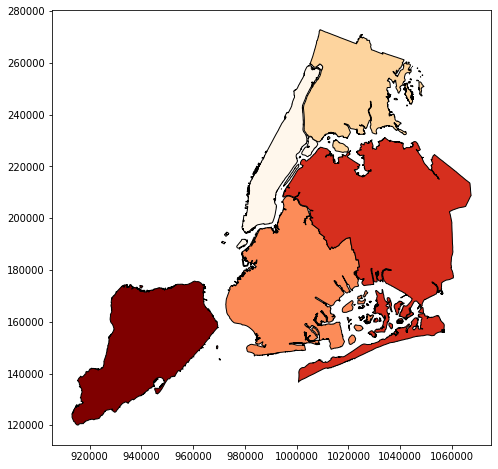

In [139]:
ax = boros.plot(cmap='OrRd', edgecolor = 'black',figsize = (8,8))

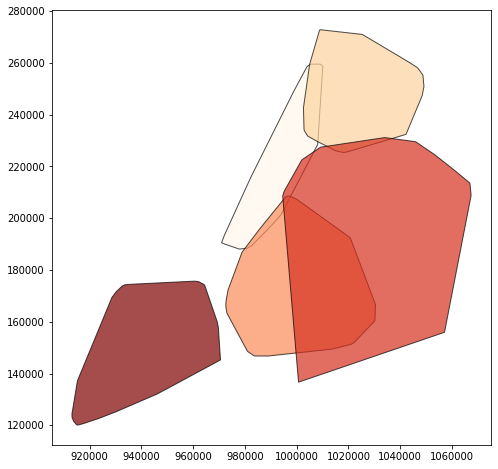

In [142]:
boros['geometry'].convex_hull.plot(cmap='OrRd', edgecolor = 'black',figsize = (8,8),alpha = 0.7)


To demonstrate a more complex operation, we’ll generate a GeoSeries containing 2000 random points:

In [146]:
from shapely.geometry import Point
xmin, xmax, ymin, ymax = 900000, 1080000, 120000, 280000
xc = (xmax - xmin) * np.random.random(2000) + xmin
yc = (ymax - ymin) * np.random.random(2000) + ymin
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
pts

0        POINT (933551.857 138004.651)
1        POINT (962504.940 196028.854)
2        POINT (913963.375 161291.703)
3        POINT (998130.174 259827.657)
4        POINT (949979.571 197899.531)
                     ...              
1995    POINT (1068841.786 231155.675)
1996    POINT (1077823.109 137183.058)
1997     POINT (909932.598 172510.416)
1998    POINT (1070882.360 267495.569)
1999     POINT (916982.721 155262.269)
Length: 2000, dtype: geometry

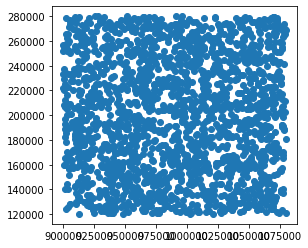

In [151]:
# use markersize to set the point size
pts.plot()

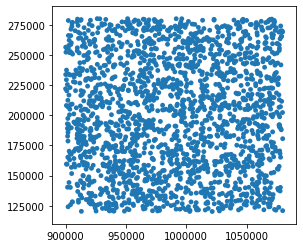

In [150]:
# Now draw a circle with fixed radius around each point:
circles = pts.buffer(2000)
circles.plot()

In [154]:
# We can collapse these circles into a single shapely MultiPolygon geometry with
mp = circles.unary_union
mp
# mp is a polygon, have no .plot() attribute

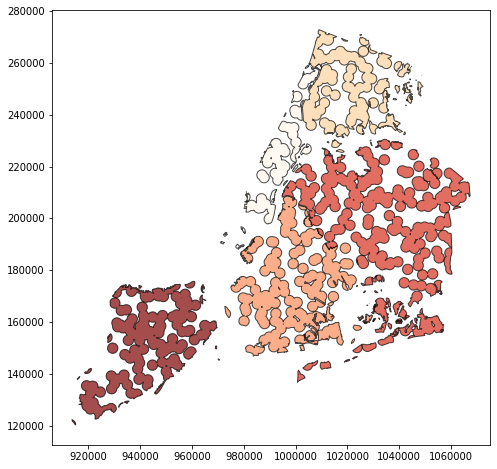

In [156]:
# To extract the part of this geometry contained in each borough, we can just use:
holes = boros['geometry'].intersection(mp)
holes.plot(cmap='OrRd', edgecolor = 'black',figsize = (8,8),alpha = 0.7)

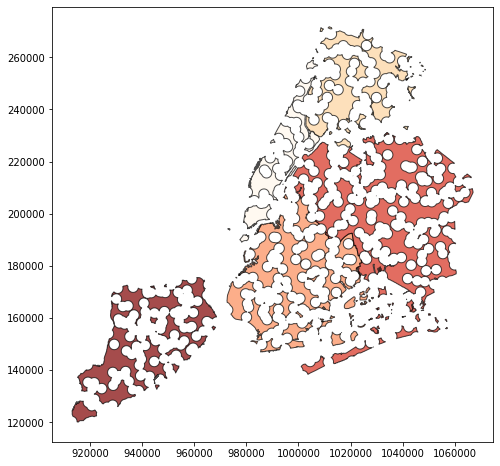

In [157]:
# and to get the area outside of the holes:
boros_with_holes = boros['geometry'].difference(mp)
boros_with_holes.plot(cmap='OrRd', edgecolor = 'black',figsize = (8,8),alpha = 0.7)

Note that this can be simplified a bit, since geometry is available as an attribute on a GeoDataFrame, and the intersection and difference methods are implemented with the “&” and “-” operators, respectively. For example, the latter could have been expressed simply as boros.geometry - mp.

It’s easy to do things like calculate the fractional area in each borough that are in the holes:

In [158]:
holes.area / boros.geometry.area

BoroCode
1    0.569175
2    0.608195
3    0.606477
4    0.588648
5    0.615538
dtype: float64

## Set-Operations with Overlay
When working with multiple spatial datasets – especially multiple polygon or line datasets – users often wish to create new shapes based on places where those datasets overlap (or don’t overlap). These manipulations are often referred using the language of sets – intersections, unions, and differences. These types of operations are made available in the geopandas library through the overlay function.

The basic idea is demonstrated by the graphic below but keep in mind that overlays operate at the DataFrame level, not on individual geometries, and the properties from both are retained. In effect, for every shape in the first GeoDataFrame, this operation is executed against every other shape in the other GeoDataFrame:
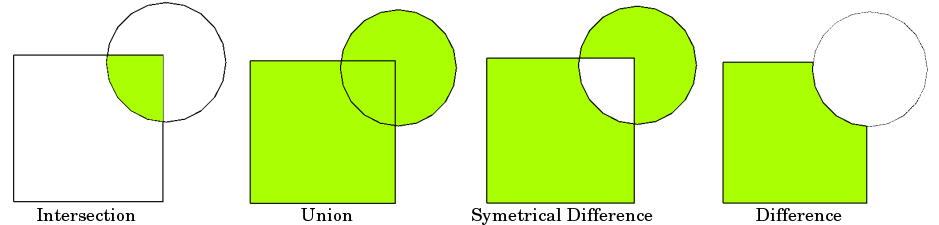
(Note to users familiar with the shapely library: overlay can be thought of as offering versions of the standard shapely set-operations that deal with the complexities of applying set operations to two GeoSeries. The standard shapely set-operations are also available as GeoSeries methods.)

## The different Overlay operations
First, we create some example data:

In [172]:
gpd.options.display_precision = 0

In [160]:
from shapely.geometry import Polygon

polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),
                               Polygon([(2,2), (4,2), (4,4), (2,4)])])


polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),
                               Polygon([(3,3), (5,3), (5,5), (3,5)])])
 

df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

In [173]:
df1

geometry  df1
0  POLYGON ((0 0, 2 0, 2 2, 0 2, 0 0))    1
1  POLYGON ((2 2, 4 2, 4 4, 2 4, 2 2))    2

In [174]:
df2

geometry  df2
0  POLYGON ((1 1, 3 1, 3 3, 1 3, 1 1))    1
1  POLYGON ((3 3, 5 3, 5 5, 3 5, 3 3))    2

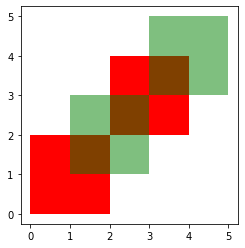

In [163]:
# These two GeoDataFrames have some overlapping areas:
ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5);

We illustrate the different overlay modes with the above example. The overlay function will determine the set of all individual geometries from overlaying the two input GeoDataFrames. This result covers the area covered by the two input GeoDataFrames, and also preserves all unique regions defined by the combined boundaries of the two GeoDataFrames.

When using how='union', all those possible geometries are returned:

In [175]:
res_union = gpd.overlay(df1, df2, how='union')
res_union

df1  df2                                           geometry
0  1.0  1.0                POLYGON ((1 2, 2 2, 2 1, 1 1, 1 2))
1  2.0  1.0                POLYGON ((2 2, 2 3, 3 3, 3 2, 2 2))
2  2.0  2.0                POLYGON ((3 4, 4 4, 4 3, 3 3, 3 4))
3  1.0  NaN      POLYGON ((0 0, 0 2, 1 2, 1 1, 2 1, 2 0, 0 0))
4  2.0  NaN  MULTIPOLYGON (((2 3, 2 4, 3 4, 3 3, 2 3)), ((3...
5  NaN  1.0  MULTIPOLYGON (((1 2, 1 3, 2 3, 2 2, 1 2)), ((2...
6  NaN  2.0      POLYGON ((3 4, 3 5, 5 5, 5 3, 4 3, 4 4, 3 4))

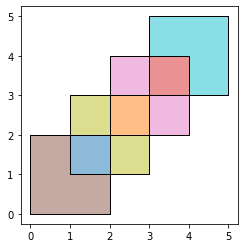

In [168]:
ax = res_union.plot(alpha=0.5, cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

The other how operations will return different subsets of those geometries. With how='intersection', it returns only those geometries that are contained by both GeoDataFrames:

In [176]:
res_intersection = gpd.overlay(df1, df2, how='intersection')

res_intersection

df1  df2                             geometry
0    1    1  POLYGON ((1 2, 2 2, 2 1, 1 1, 1 2))
1    2    1  POLYGON ((2 2, 2 3, 3 3, 3 2, 2 2))
2    2    2  POLYGON ((3 4, 4 4, 4 3, 3 3, 3 4))

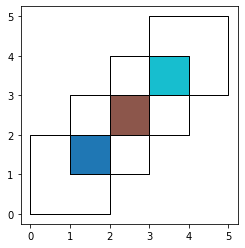

In [177]:
ax = res_intersection.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

`how='symmetric_difference'` is the opposite of `'intersection'` and returns the geometries that are only part of one of the GeoDataFrames but not of both:

In [179]:
res_symdiff = gpd.overlay(df1, df2, how='symmetric_difference')
res_symdiff

df1  df2                                           geometry
0  1.0  NaN      POLYGON ((0 0, 0 2, 1 2, 1 1, 2 1, 2 0, 0 0))
1  2.0  NaN  MULTIPOLYGON (((2 3, 2 4, 3 4, 3 3, 2 3)), ((3...
2  NaN  1.0  MULTIPOLYGON (((1 2, 1 3, 2 3, 2 2, 1 2)), ((2...
3  NaN  2.0      POLYGON ((3 4, 3 5, 5 5, 5 3, 4 3, 4 4, 3 4))

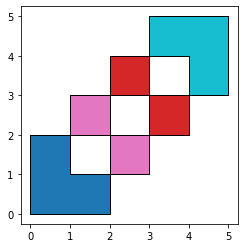

In [182]:
ax = res_symdiff.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

To obtain the geometries that are part of df1 but are not contained in df2, you can use `how='difference'`:

In [183]:
res_difference = gpd.overlay(df1, df2, how='difference')

res_difference

geometry  df1
0      POLYGON ((0 0, 0 2, 1 2, 1 1, 2 1, 2 0, 0 0))    1
1  MULTIPOLYGON (((2 3, 2 4, 3 4, 3 3, 2 3)), ((3...    2

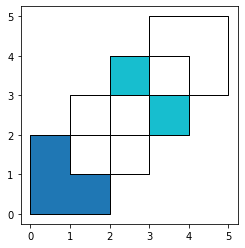

In [184]:
ax = res_difference.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

In [186]:
res_difference2 = gpd.overlay(df2, df1, how='difference')

res_difference2

geometry  df2
0  MULTIPOLYGON (((1 2, 1 3, 2 3, 2 2, 1 2)), ((2...    1
1      POLYGON ((3 4, 3 5, 5 5, 5 3, 4 3, 4 4, 3 4))    2

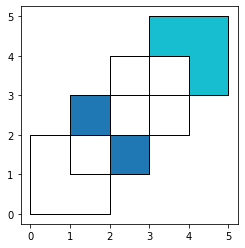

In [187]:
ax = res_difference2.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

Finally, with `how='identity'`, the result consists of the surface of df1, but with the geometries obtained from overlaying df1 with df2:

In [188]:
res_identity = gpd.overlay(df1, df2, how='identity')

res_identity

df1  df2                                           geometry
0  1.0  1.0                POLYGON ((1 2, 2 2, 2 1, 1 1, 1 2))
1  2.0  1.0                POLYGON ((2 2, 2 3, 3 3, 3 2, 2 2))
2  2.0  2.0                POLYGON ((3 4, 4 4, 4 3, 3 3, 3 4))
3  1.0  NaN      POLYGON ((0 0, 0 2, 1 2, 1 1, 2 1, 2 0, 0 0))
4  2.0  NaN  MULTIPOLYGON (((2 3, 2 4, 3 4, 3 3, 2 3)), ((3...

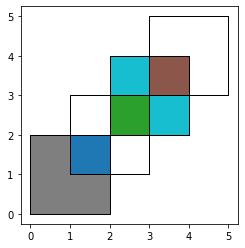

In [192]:
ax = res_identity.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

In [193]:
res_identity2 = gpd.overlay(df2, df1, how='identity')

res_identity2

df2  df1                                           geometry
0  1.0  1.0                POLYGON ((1 1, 1 2, 2 2, 2 1, 1 1))
1  1.0  2.0                POLYGON ((2 3, 3 3, 3 2, 2 2, 2 3))
2  2.0  2.0                POLYGON ((3 3, 3 4, 4 4, 4 3, 3 3))
3  1.0  NaN  MULTIPOLYGON (((1 2, 1 3, 2 3, 2 2, 1 2)), ((2...
4  2.0  NaN      POLYGON ((3 4, 3 5, 5 5, 5 3, 4 3, 4 4, 3 4))

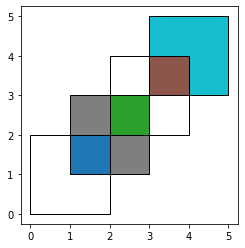

In [194]:
ax = res_identity2.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');

## Overlay Countries Example
First, we load the countries and cities example datasets and select :

In [196]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

capitals = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# Select South Amarica and some columns
countries = world[world['continent'] == "South America"]

countries = countries[['geometry', 'name']]

# Project to crs that uses meters as distance measure
countries = countries.to_crs('+init=epsg:3395')

capitals = capitals.to_crs('+init=epsg:3395')

To illustrate the overlay function, consider the following case in which one wishes to identify the “core” portion of each country – defined as areas within 500km of a capital – using a GeoDataFrame of countries and a GeoDataFrame of capitals.

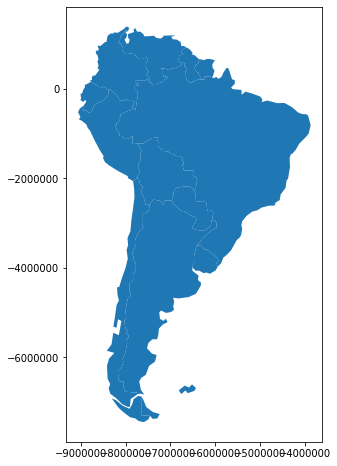

In [198]:
# Look at countries:
countries.plot(figsize = (8,8));

In [199]:
# Now buffer cities to find area within 500km.
# Check CRS -- World Mercator, units of meters.
capitals.crs

'+init=epsg:3395'

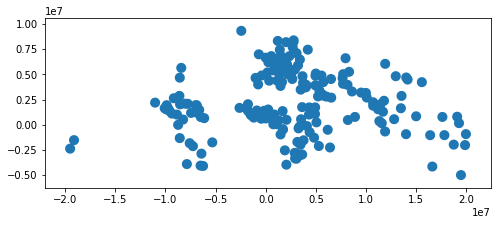

In [200]:
# make 500km buffer
capitals['geometry']= capitals.buffer(500000)

capitals.plot(figsize = (8,8));

To select only the portion of countries within 500km of a capital, we specify the how option to be “intersect”, which creates a new set of polygons where these two layers overlap:

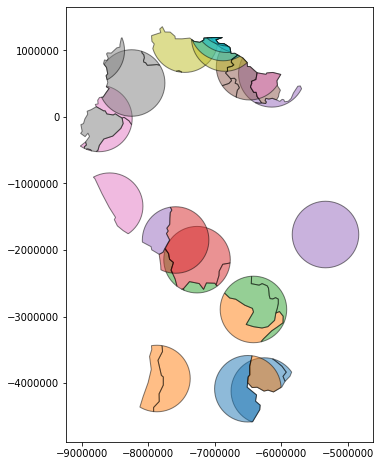

In [203]:
country_cores = gpd.overlay(countries, capitals, how='intersection')

country_cores.plot(alpha=0.5, edgecolor='k', cmap='tab10',figsize = (8,8));

Changing the “how” option allows for different types of overlay operations. For example, if we were interested in the portions of countries far from capitals (the peripheries), we would compute the difference of the two.

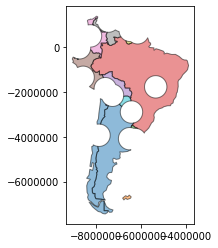

In [204]:
country_peripheries = gpd.overlay(countries, capitals, how='difference')

country_peripheries.plot(alpha=0.5, edgecolor='k', cmap='tab10');

## Aggregation with dissolve
Spatial data are often more granular than we need. For example, we might have data on sub-national units, but we’re actually interested in studying patterns at the level of countries.

In a non-spatial setting, when all we need are summary statistics of the data, we aggregate our data using the groupby function. But for spatial data, we sometimes also need to aggregate geometric features. In the geopandas library, we can aggregate geometric features using the dissolve function.

dissolve can be thought of as doing three things: (a) it dissolves all the geometries within a given group together into a single geometric feature (using the unary_union method), and (b) it aggregates all the rows of data in a group using groupby.aggregate(), and (c) it combines those two results.

### dissolve Example
Suppose we are interested in studying continents, but we only have country-level data like the country dataset included in geopandas. We can easily convert this to a continent-level dataset.

First, let’s look at the most simple case where we just want continent shapes and names. By default, dissolve will pass 'first' to groupby.aggregate.

geometry
continent                                                       
Africa         MULTIPOLYGON (((50 -12, 50 -13, 50 -14, 50 -15...
Antarctica     MULTIPOLYGON (((-164 -79, -164 -79, -163 -78, ...
Asia           MULTIPOLYGON (((120 -10, 119 -10, 120 -9, 120 ...
Europe         MULTIPOLYGON (((-52 4, -52 3, -53 3, -53 2, -5...
North America  MULTIPOLYGON (((-62 11, -61 11, -61 11, -61 10...

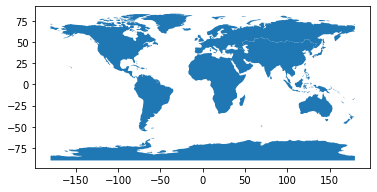

In [205]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[['continent', 'geometry']]

continents = world.dissolve(by='continent')

continents.plot();

continents.head()

If we are interested in aggregate populations, however, we can pass different functions to the dissolve method to aggregate populations using the aggfunc = argument:

geometry     pop_est
continent                                                                   
Africa         MULTIPOLYGON (((50 -12, 50 -13, 50 -14, 50 -15...  1219176238
Antarctica     MULTIPOLYGON (((-164 -79, -164 -79, -163 -78, ...        4050
Asia           MULTIPOLYGON (((120 -10, 119 -10, 120 -9, 120 ...  4389144868
Europe         MULTIPOLYGON (((-52 4, -52 3, -53 3, -53 2, -5...   746398461
North America  MULTIPOLYGON (((-62 11, -61 11, -61 11, -61 10...   573042112

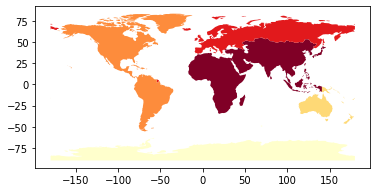

In [207]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[['continent', 'geometry', 'pop_est']]

continents = world.dissolve(by='continent', aggfunc='sum') # similar as groupby

continents.plot(column = 'pop_est', scheme='quantiles', cmap='YlOrRd');

continents.head()

Dissolve Arguments
The aggfunc = argument defaults to ‘first’ which means that the first row of attributes values found in the dissolve routine will be assigned to the resultant dissolved geodataframe. However it also accepts other summary statistic options as allowed by pandas.groupby() including:

‘first’

‘last’

‘min’

‘max’

‘sum’

‘mean’

‘median’

## Merging Data
There are two ways to combine datasets in geopandas – attribute joins and spatial joins.

In an attribute join, a GeoSeries or GeoDataFrame is combined with a regular pandas Series or DataFrame based on a common variable. This is analogous to normal merging or joining in pandas.

In a Spatial Join, observations from to GeoSeries or GeoDataFrames are combined based on their spatial relationship to one another.

In the following examples, we use these datasets:

In [208]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# For attribute join
country_shapes = world[['geometry', 'iso_a3']]

country_names = world[['name', 'iso_a3']]

# For spatial join
countries = world[['geometry', 'name']]

countries = countries.rename(columns={'name':'country'})

## Attribute Joins
Attribute joins are accomplished using the merge method. In general, it is recommended to use the merge method called from the spatial dataset. With that said, the stand-alone merge function will work if the GeoDataFrame is in the left argument; if a DataFrame is in the left argument and a GeoDataFrame is in the right position, the result will no longer be a GeoDataFrame.

For example, consider the following merge that adds full names to a GeoDataFrame that initially has only ISO codes for each country by merging it with a pandas DataFrame.

In [210]:
# `country_shapes` is GeoDataFrame with country shapes and iso codes
country_shapes.head()

geometry iso_a3
0  MULTIPOLYGON (((180 -16, 180 -17, 179 -17, 179...    FJI
1  POLYGON ((34 -1, 34 -1, 38 -3, 38 -4, 39 -5, 3...    TZA
2  POLYGON ((-9 28, -9 28, -9 27, -9 26, -12 26, ...    ESH
3  MULTIPOLYGON (((-123 49, -123 49, -125 50, -12...    CAN
4  MULTIPOLYGON (((-123 49, -120 49, -117 49, -11...    USA

In [211]:
# `country_names` is DataFrame with country names and iso codes
country_names.head()

name iso_a3
0                      Fiji    FJI
1                  Tanzania    TZA
2                 W. Sahara    ESH
3                    Canada    CAN
4  United States of America    USA

In [212]:
# Merge with `merge` method on shared variable (iso codes):
country_shapes = country_shapes.merge(country_names, on='iso_a3')
country_shapes.head()

geometry iso_a3  \
0  MULTIPOLYGON (((180 -16, 180 -17, 179 -17, 179...    FJI   
1  POLYGON ((34 -1, 34 -1, 38 -3, 38 -4, 39 -5, 3...    TZA   
2  POLYGON ((-9 28, -9 28, -9 27, -9 26, -12 26, ...    ESH   
3  MULTIPOLYGON (((-123 49, -123 49, -125 50, -12...    CAN   
4  MULTIPOLYGON (((-123 49, -120 49, -117 49, -11...    USA   

                       name  
0                      Fiji  
1                  Tanzania  
2                 W. Sahara  
3                    Canada  
4  United States of America

## Spatial Joins
In a Spatial Join, two geometry objects are merged based on their spatial relationship to one another.

In [213]:
# One GeoDataFrame of countries, one of Cities.
# Want to merge so we can get each city's country.
countries.head()

geometry                   country
0  MULTIPOLYGON (((180 -16, 180 -17, 179 -17, 179...                      Fiji
1  POLYGON ((34 -1, 34 -1, 38 -3, 38 -4, 39 -5, 3...                  Tanzania
2  POLYGON ((-9 28, -9 28, -9 27, -9 26, -12 26, ...                 W. Sahara
3  MULTIPOLYGON (((-123 49, -123 49, -125 50, -12...                    Canada
4  MULTIPOLYGON (((-123 49, -120 49, -117 49, -11...  United States of America

In [214]:
 cities.head()


name       geometry
0  Vatican City  POINT (12 42)
1    San Marino  POINT (12 44)
2         Vaduz  POINT (10 47)
3    Luxembourg   POINT (6 50)
4       Palikir  POINT (158 7)

In [215]:
# Execute spatial join
cities_with_country = gpd.sjoin(cities, countries, how="inner", op='intersects')

cities_with_country.head()

name       geometry  index_right  country
0    Vatican City  POINT (12 42)          141    Italy
1      San Marino  POINT (12 44)          141    Italy
192          Rome  POINT (12 42)          141    Italy
2           Vaduz  POINT (10 47)          114  Austria
184        Vienna  POINT (16 48)          114  Austria

In [216]:
cities

name         geometry
0    Vatican City    POINT (12 42)
1      San Marino    POINT (12 44)
2           Vaduz    POINT (10 47)
3      Luxembourg     POINT (6 50)
4         Palikir    POINT (158 7)
..            ...              ...
197         Cairo    POINT (31 30)
198         Tokyo   POINT (140 36)
199         Paris     POINT (2 49)
200      Santiago  POINT (-71 -33)
201     Singapore    POINT (104 1)

[202 rows x 2 columns]

## Sjoin Arguments
sjoin.() has two core arguments: how and op.

**op**

The `op` argument specifies how `eopandas` decides whether or not to join the attributes of one object to another. There are three different join options as follows:

- intersects: The attributes will be joined if the boundary and interior of the object intersect in any way with the boundary and/or interior of the other object.

- within: The attributes will be joined if the object’s boundary and interior intersect only with the interior of the other object (not its boundary or exterior).

- contains: The attributes will be joined if the object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all.

You can read more about each join type in the Shapely [documentation](https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates).

**how**

The how argument specifies the type of join that will occur and which geometry is retained in the resultant geodataframe. It accepts the following options:

- left: use the index from the first (or left_df) geodataframe that you provide to sjoin; retain only the left_df geometry column

- right: use index from second (or right_df); retain only the right_df geometry column

- inner: use intersection of index values from both geodataframes; retain only the left_df geometry column

Note more complicated spatial relationships can be studied by combining geometric operations with spatial join. To find all polygons within a given distance of a point, for example, one can first use the buffer method to expand each point into a circle of appropriate radius, then intersect those buffered circles with the polygons in question.

### Sjoin Performance
Existing spatial indexes on either left_df or right_df will be reused when performing an sjoin. If neither df has a spatial index, a spatial index will be generated for the longer df. If both have a spatial index, the right_df’s index will be used preferentially. Performance of multiple sjoins in a row involving a common GeoDataFrame may be improved by pre-generating the spatial index of the common GeoDataFrame prior to performing sjoins using df1.sindex.

In [ ]:
df1 = # a GeoDataFrame with data
df2 = # a second GeoDataFrame
df3 = # a third GeoDataFrame

# pre-generate sindex on df1 if it doesn't already exist
df1.sindex

sjoin(df1, df2, ...)
# sindex for df1 is reused
sjoin(df1, df3, ...)
# sindex for df1 is reused again

## Geocoding
geopandas supports geocoding (i.e., converting place names to location on Earth) through [geopy](https://geopy.readthedocs.io/en/stable/), an optional dependency of geopandas. The following example shows how to get the locations of boroughs in New York City, and plots those locations along with the detailed borough boundary file included within geopandas.

In [217]:
boros = gpd.read_file(gpd.datasets.get_path("nybb"))

boros.BoroName

0    Staten Island
1           Queens
2         Brooklyn
3        Manhattan
4            Bronx
Name: BoroName, dtype: object

In [219]:
boro_locations = gpd.tools.geocode(boros.BoroName)
boro_locations

geometry                       address
0  POINT (-74 41)        Staten Island, NY, USA
1  POINT (-74 41)               Queens, NY, USA
2  POINT (-74 41)             Brooklyn, NY, USA
3  POINT (-74 41)  Manhattan, New York, NY, USA
4  POINT (-74 41)                Bronx, NY, USA

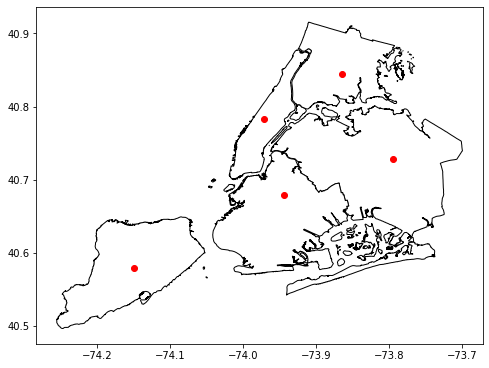

In [221]:
fig, ax = plt.subplots(figsize = (8,8))

boros.to_crs({"init": "epsg:4326"}).plot(ax=ax, color="white", edgecolor="black");

boro_locations.plot(ax=ax, color="red");

By default, the geocode function uses the [GeoCode.Farm geocoding API](https://geocode.farm/) with a rate limitation applied. But a different geocoding service can be specified with the `provider` keyword.

The argument to `provider` can either be a string referencing geocoding services, such as `'google', 'bing', 'yahoo', and 'openmapquest'`, or an instance of a Geocoder from geopy. See `geopy.geocoders.SERVICE_TO_GEOCODER` for the full list. For many providers, parameters such as API keys need to be passed as **kwargs in the geocode call.

For example, to use the OpenStreetMap Nominatim geocoder, you need to specify a user agent:

`geopandas.tools.geocode(boros.BoroName, provider='nominatim', user_agent="my-application")`

## Missing and empty geometries
GeoPandas supports, just like in pandas, the concept of missing values (NA or null values). But for geometry values, we have an additional concept of empty geometries:

- Empty geometries are actual geometry objects but that have no coordinates (and thus also no area, for example). They can for example originate from taking the intersection of two polygons that have no overlap. The scalar object (when accessing a single element of a GeoSeries) is still a Shapely geometry object.

- Missing geometries are unknown values in a GeoSeries. They will typically be propagated in operations (for example in calculations of the area or of the intersection), or ignored in reductions such as unary_union. The scalar object (when accessing a single element of a GeoSeries) is the Python None object.

In [223]:
#Consider the following example GeoSeries with one polygon, 
# one missing value and one empty polygon:

from shapely.geometry import Polygon

s = gpd.GeoSeries([Polygon([(0, 0), (1, 1), (0, 1)]), None, Polygon([])])

s

0    POLYGON ((0 0, 1 1, 0 1, 0 0))
1                              None
2          GEOMETRYCOLLECTION EMPTY
dtype: geometry

In [224]:
s.area

0    0.5
1    NaN
2    0.0
dtype: float64

In [225]:
s.union(Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]))

0    POLYGON ((0 1, 1 1, 1 0, 0 0, 0 1))
1                                   None
2    POLYGON ((0 0, 0 1, 1 1, 1 0, 0 0))
dtype: geometry

In [226]:
s.intersection(Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]))

0    POLYGON ((1 1, 0 0, 0 1, 1 1))
1                              None
2          GEOMETRYCOLLECTION EMPTY
dtype: geometry

The GeoSeries.isna() method will only check for missing values and not for empty geometries:

In [233]:
s.isna()

0    False
1     True
2    False
dtype: bool

On the other hand, if you want to know which values are empty geometries, you can use the GeoSeries.is_empty attribute:

In [229]:
s.is_empty

0    False
1    False
2     True
dtype: bool

To get only the actual geometry objects that are neiter missing nor empty, you can use a combination of both:

In [232]:
s.is_empty | s.isna()

0    False
1     True
2     True
dtype: bool

In [231]:
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)